**Coursebook: Recurrent Neural Network (RNN) for Text Classification**
- Course Length: 4.5 hours
- Last Updated: August 2022

___

- Developed by [Algoritma](https://algorit.ma)'s product division and instructors team

# Background
The coursebook is part of the Digital Amoeba: Deep Learning in Python prepared by [Algoritma](https://algorit.ma/). The coursebook is intended for a restricted audience only, i.e. the individuals and organizations having received this coursebook directly from the training organization. It may not be reproduced, distributed, translated or adapted in any form outside these individuals and organizations without permission.

Algoritma is a data science education center based in Jakarta. We organize workshops and training programs to help working professionals and students gain mastery in various data science sub-fields: data visualization, machine learning, data modeling, statistical inference etc.

**Course Objective**:

**Sequence Models**
- Bidirectional and Deep RNN
- Gated Recurrent Unit (GRU)

**Building RNN for Text Classification using Keras Tensorflow**
- Celullar Service Provider Data Tweets: Sentiment Analysis of User Satisfaction Level of Indonesian Cellular Telecommunication Service Providers

# Libraries

In [56]:
# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import tensorflow as tf
import tensorflow.keras as keras

# set seed
import random
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import keras
from keras import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout
from keras import regularizers
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import pickle

# Sentiment Analysis

Sentiment Analysis is an analysis that is usually used to get sentiment information from the sentences contained in the text. In the world of Data Science, techniques or methods that can be used in sentiment analysis are usually referred to as **Natural Language Processing (NLP)**. The results of sentiment analysis using NLP can be grouped into three groups depending on their use, such as:

* **Fine-grained:** This type of analysis allows someone to give an assessment of a text and the assessment has a range. This analysis is widely used to evaluate or review the services of a restaurant or the services of an e-commerce store.

* **Emotion detection:** As the name implies, this analysis is used to find out the emotions of a person, for example, someone is happy, sad, angry or frustrated. However, this type of analysis is very subjective because everyone uses different words to express their emotions, for example: “Terrible! This food is really delicious”, the word severe in the sentence can be described as a positive word although usually the word severe tends to have a negative meaning.
 
* **Aspect-based sentiment analysis:** This analysis technique can be used to determine whether a comment or sentence contains positive, negative and neutral aspects. This type of analysis is widely used to find out whether a news item about a particular stock contains negative or positive elements, because a news containing positive elements can affect a stock price to be higher and vice versa.

> 💡 From the three uses described above, the focus of the use of sentiment analysis that will be dissected more deeply in this documentation is **aspect-based sentiment analysis**. We will try to use this type of analysis to find out whether a customer review has positive or negative aspects.

Broadly speaking, to perform aspect-based sentiment analysis there are 2 steps that must be taken, namely, Data Pre-Processing & Model Preparation.

* **Data Pre-Processing:** Text preprocessing is a process for selecting text data to become more structured by going through a series of stages. In addition, text preprocessing is an implementation of text mining. Text mining itself is a data mining activity, where data is usually taken in the form of text sourced from documents that have goals to find keywords that represent a set of documents so that later analysis of the relationship between these documents can be carried out.

* **Model Preparation:** In this step we will start working with the model that will be used. Some of the steps that will be carried out first here are cross validation, model evaluation & model interpretation. The details of each stage that will be carried out in the Model Preparation step will be explained in more detail in each of its sub-sections.

# Use Case: Sentiment Classification with RNN

In this section, we will implement RNN on sentiment analysis dataset collected from the social networking site Twitter related to public sentiment towards cellular service providers in Indonesia totaling 300 tweets. The dataset has 2 classes of sentiment, namely positive and negative. Prior to publication, this dataset has been pre-processed as follows:

- Replacing service provider name/identity with PROVIDER_NAME tag 
- Replacing URL addresses with URL tag 
- Replacing the user's @mention with the USER_MENTION tag
- Replacing the product name with the PRODUCT_NAME tag

> Dataset reference: [Rofiqoh, U., Perdana, R.S., & Fauzi, M.A. (2017) research](https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_tweet_sentiment_cellular_service_provider.csv)

## Load Dataset

Load `dataset_tweet_sentiment_cellular_service_provider.csv` using `pandas`

In [57]:
df = pd.read_csv('data_input/dataset_tweet_sentiment_cellular_service_provider.csv').drop(columns='Id')
df.head()

,Sentiment,Text Tweet
0,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


Let's explore the proportion of target variable `Sentiment`

In [58]:
df.groupby('Sentiment').count() / df.shape[0]

,Text Tweet
Sentiment,
negative,0.536667
positive,0.463333


Visualize it:

<AxesSubplot:>

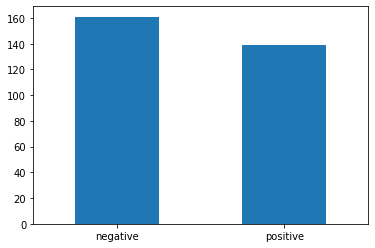

In [59]:
df['Sentiment'].value_counts().plot(kind='bar', rot=0)

> 💡 Note: We often expect the proportion of target variable to be balanced, so that our model can learn equally.

## Target Preprocessing

To fit the target ($y$) in keras, we must encode the label to numeric values. We map the 'positive' label to 1 and 'negative' label to 0.

In [60]:
df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,Sentiment,Text Tweet
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>


## Text Preprocessing

Text preprocessing is a method to clean the text data and make it ready to feed data to the model. Text data contains noise in various forms like emotions, punctuation, text in a different case. Raw text data might contain unwanted or unimportant text due to which our results might not give efficient accuracy, and might make it hard to understand and analyze. We should not feed raw data without preprocessing to build models because **the preprocessing of text directly improves the model's performance**. If we feed data without performing any text preprocessing techniques, the build models will not learn the real significance of the data. In some cases, if we feed raw data without any preprocessing techniques the models will get confused and give random results. 

**💬 Discussion**

In your opinion, by looking at the data we have, what kind of text preprocessing do we need to do?

*Answer:*
> - remove words or clause that doesn't affect sentiment in this particular data, e.g., `selamat pagi`, `selamat malam`
> - URL, punctuation, symbols, emoticon
> - remove stopwords (words that often appear, and don't really have any meaning) e.g., `di`, `ini`, `itu`, `yang`
> - handling `oov` (*out of vocabulary*) words

### Case Folding

Case folding is the process of uniforming the text of the letters on all documents in the corpus. In text classification, case folding is generally done by uniforming the document text in the corpus into all **lowercase letters**. Lower case folding is done to homogenize all letterforms into lowercase letters so that there are no differences in words/terms during feature extraction due to differences in letterforms.

In [61]:
df['text_lower'] = df['Text Tweet'].str.lower()
df.head()

,Sentiment,Text Tweet,text_lower
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,<user_mention> #boikot_<provider_name> gunakan...
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...","saktinya balik lagi, alhamdulillah :v <provide..."
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi <provider_name> bisa bantu kenap...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear <provider_name> akhir2 ini jaringan data ...
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta <provider_name>


> 💡 **Tips:** In preprocessing text data, the best practice is to **create a new column for each preprocessing**. This practice is helpful when we want to refine the evaluation of the model with different preprocessing steps.

### Text Cleansing

Text cleansing consists of **removing unnecessary data attributes** such as certain punctuation marks (period, comma, semicolon, quotes, and so on) and Uniform Resource Locator (URL) addresses. Specifically for Twitter data, several other attributes are not needed in the classification process, namely the RT (re-tweet) character and username (the name of the account that wrote the tweet). The URL, RT/mention, and product name in this dataset have been replaced with tags.

> During text cleansing, it is common to use **regular expression (regex)**. It is a sequence of characters that specifies a search pattern in text. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings, or for input validation. Here are references to study more about regex:
> - https://www.w3schools.com/python/python_regex.asp
> - https://regex101.com/

In [62]:
import re # regex
import string

In [63]:
text = "testes123 <provider_name> ..."
text.replace('<provider_name>', '')

'testes123  ...'

In [64]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

The function below is a custom function that can be customized based on the context of the text data used.

In [65]:
# note: this function is customizable depends on your case
def text_cleansing(text):
    
    # remove tags
    text = text.replace('<provider_name>', '')
    text = text.replace('<url>', '')
    text = text.replace('<user_mention>', '')
    text = text.replace('<product_name>', '')
    
    # remove non ASCII (emoticon, chinese word, etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    
    # remove digits (using regex) -> subtitute
    text = re.sub('\d+', '', text)
    
    # remove punctuation, reference: https://stackoverflow.com/a/34294398
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove whitespace in the beginning and end of sentence
    text = text.strip()
    
    # remove extra whitespace in the middle of sentence (using regex)
    text = re.sub('\s+', ' ', text)
    
    return text

Let's us see how the function `text_cleansing` works on `sample_text`

In [66]:
sample_text = df['text_lower'][8]
sample_text

'keluhan gak ditanggapi. bikin emosi aja. pulsaku dicuri terus. soak deh. masa setiap hari pulsa berkurang 1500-2100 bisa 2-3*/hari'

In [67]:
sample_text_clean = text_cleansing(sample_text)
sample_text_clean

'keluhan gak ditanggapi bikin emosi aja pulsaku dicuri terus soak deh masa setiap hari pulsa berkurang bisa hari'

We can iteratively apply a function to a column by using `.apply()` method

In [68]:
df['text_clean'] = df['text_lower'].apply(lambda x: text_cleansing(x))
df.head()

,Sentiment,Text Tweet,text_lower,text_clean
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,<user_mention> #boikot_<provider_name> gunakan...,boikot gunakan produk bangsa sendiri
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...","saktinya balik lagi, alhamdulillah :v <provide...",saktinya balik lagi alhamdulillah v
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi <provider_name> bisa bantu kenap...,selamat pagi bisa bantu kenapa di dalam kamar ...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear <provider_name> akhir2 ini jaringan data ...,dear akhir ini jaringan data lemot banget pada...
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta <provider_name>,selamat malam pendusta


### Text Normalization

Furthermore, the data preprocessing is carried out with the text normalization process to change the **informal word forms into formal ones**. Informal word forms that are often used by Indonesian netizens in writing tweets include:

1. words that show feelings (eg hiks (sad), wkwkwk/wkwk (laughs), huhuhu (crying), and others);
2. repetition of characters to highlight certain words (eg: lamaaaa (long time), sorryyyyy (sorry), and others);
3. omission of vowels (eg no (no), don't (don't), and others);
4. the use of slang words (eg: ciyus (serious), dah (already), and others);
5. replacement of letters with numbers (eg s4ya (me), disk0n (discounts), and others).

> We use typo dictionary and abbreviations obtained from a combination of typo/abbreviation dictionaries from [Ibrohim dan Budi (2019)](https://github.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection).

In [69]:
# note: the dictionary is customizable depends on your case
normalized_word = pd.read_csv('data_input/new_kamusalay.csv', header=None)
data_dict = dict(zip(normalized_word[0], normalized_word[1]))
len(data_dict)

15166

We define function `normalize_text` to map an informal to formal sentence.

In [70]:
def normalize_text(text):
    return ' '.join(data_dict.get(word, word) for word in text.split())

The function above is written using [Python's list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). If you are not familiar with that, you can refer to the following version:

```{python}
def normalize_text(text):
    # temporary list
    result = []
    
    # split sentence into list of words
    split_text = text.split()
    
    # loop for each word
    for word in split_text:
        new_word = data_dict.get(word, word) # return normalized word if it exists in the dictionary
        result.append(new_word)
    
    # combine list of words into sentence
    combine_text = ''.join(result)
    
    return combine_text
```

In [71]:
# before
sample_text_clean

'keluhan gak ditanggapi bikin emosi aja pulsaku dicuri terus soak deh masa setiap hari pulsa berkurang bisa hari'

In [72]:
# after
sample_text_normalized = normalize_text(sample_text_clean)
sample_text_normalized

'keluhan tidak ditanggapi bikin emosi saja pulsaku dicuri terus soak deh masa setiap hari pulsa berkurang bisa hari'

We can iteratively apply a function to a column by using `.apply()` method

In [73]:
df['text_normalized'] = df['text_clean'].apply(lambda x: normalize_text(x))

In [74]:
df.head()

,Sentiment,Text Tweet,text_lower,text_clean,text_normalized
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,<user_mention> #boikot_<provider_name> gunakan...,boikot gunakan produk bangsa sendiri,boikot gunakan produk bangsa sendiri
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...","saktinya balik lagi, alhamdulillah :v <provide...",saktinya balik lagi alhamdulillah v,saktinya balik lagi alhamdulillah v
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi <provider_name> bisa bantu kenap...,selamat pagi bisa bantu kenapa di dalam kamar ...,selamat pagi bisa bantu kenapa di dalam kamar ...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear <provider_name> akhir2 ini jaringan data ...,dear akhir ini jaringan data lemot banget pada...,dear akhir ini jaringan data lemot banget pada...
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta <provider_name>,selamat malam pendusta,selamat malam pendusta


### Stemming

Stemming is cutting affixed words into root words process. **Stemming is not a mandatory step in text preprocessing.** Sometimes we need to do stemming; sometimes, we don't. It all depends on the characteristics of the data.

> We use Nazief-Adriani algorithm (Adriani, et al., 2007) implemented using the [Sastrawi Library](https://github.com/har07/PySastrawi)

Stemming examples:

- mencuci → cuci
- berlari → lari
- berlarian → lari
- lari-larian → lari

In [75]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [76]:
# before
sample_text_normalized

'keluhan tidak ditanggapi bikin emosi saja pulsaku dicuri terus soak deh masa setiap hari pulsa berkurang bisa hari'

In [77]:
# after
sample_text_stemmed = stemmer.stem(sample_text_normalized)
sample_text_stemmed

'keluh tidak tanggap bikin emosi saja pulsa curi terus soak deh masa tiap hari pulsa kurang bisa hari'

We can iteratively apply a function to a column by using `.apply()` method.

**Disclaimer**: The stemming process will take approximately 2-3 minutes

In [78]:
df['text_stemmed'] = df['text_normalized'].apply(lambda x: stemmer.stem(x))
df.head()

,Sentiment,Text Tweet,text_lower,text_clean,text_normalized,text_stemmed
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,<user_mention> #boikot_<provider_name> gunakan...,boikot gunakan produk bangsa sendiri,boikot gunakan produk bangsa sendiri,boikot guna produk bangsa sendiri
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...","saktinya balik lagi, alhamdulillah :v <provide...",saktinya balik lagi alhamdulillah v,saktinya balik lagi alhamdulillah v,sakti balik lagi alhamdulillah v
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi <provider_name> bisa bantu kenap...,selamat pagi bisa bantu kenapa di dalam kamar ...,selamat pagi bisa bantu kenapa di dalam kamar ...,selamat pagi bisa bantu kenapa di dalam kamar ...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear <provider_name> akhir2 ini jaringan data ...,dear akhir ini jaringan data lemot banget pada...,dear akhir ini jaringan data lemot banget pada...,dear akhir ini jaring data lot banget padahal h
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta <provider_name>,selamat malam pendusta,selamat malam pendusta,selamat malam dusta


### Stopwords removal

Stopwords removal is deletion of common meaningless words such as conjunctions and others.

> We use [Bahasa Indonesia stopwords](https://github.com/masdevid/ID-Stopwords) list obtained from the research of [Tala (2003)](https://www.semanticscholar.org/paper/A-Study-of-Stemming-Effects-on-Information-in-Tala/8ed9c7d54fd3f0b1ce3815b2eca82147b771ca8f?p2df) because the stopwords are larger than the stopwords list in the Indonesian nltk library.

In [79]:
# uncomment & run this code ONCE only
# import nltk
# nltk.download('stopwords')

In [80]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

# get stopword indonesia
list_stopwords = stopwords.words('indonesian')
len(list_stopwords)

758

In [81]:
stopwords_tala = pd.read_csv('data_input/StopWords_Tala.csv')
list_stopwords = set(stopwords_tala['LEMA'])
len(list_stopwords)

44019

> 💡 Note: You can define your own stopwords list to be removed, but again, the list depends on the case.

In [82]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in list_stopwords])

The function above is written using [Python's list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). If you are not familiar with that, you can refer to the following version:

```{python}
def remove_stopwords(text):
    # temporary list
    result = []
    
    # split sentence into list of words
    split_text = text.split()
    
    # loop for each word
    for word in split_text:
        if word not in list_stopwords:
            result.append(word) # append word that not in stopwords list
            
    # combine list of words into sentence
    combine_text = ' '.join(result)

    return combine_text
```

In [83]:
# before
sample_text_stemmed

'keluh tidak tanggap bikin emosi saja pulsa curi terus soak deh masa tiap hari pulsa kurang bisa hari'

In [84]:
# after
remove_stopwords(sample_text_stemmed)

'keluh tanggap bikin emosi pulsa curi deh pulsa'

We can iteratively apply a function to a column by using `.apply()` method.

In [85]:
df['text_no_stopwords'] = df['text_stemmed'].apply(lambda x: remove_stopwords(x))

We have finished the data preprocessing, and each processing result is split into data frame column values. Separating data processing results is a good step because we do not need to repeat the preprocessing process if we need data with different preprocessing techniques. This efficiency will be evident if the data being used is large enough.

In [86]:
df.head()

,Sentiment,Text Tweet,text_lower,text_clean,text_normalized,text_stemmed,text_no_stopwords
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,<user_mention> #boikot_<provider_name> gunakan...,boikot gunakan produk bangsa sendiri,boikot gunakan produk bangsa sendiri,boikot guna produk bangsa sendiri,boikot produk bangsa
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...","saktinya balik lagi, alhamdulillah :v <provide...",saktinya balik lagi alhamdulillah v,saktinya balik lagi alhamdulillah v,sakti balik lagi alhamdulillah v,sakti alhamdulillah v
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi <provider_name> bisa bantu kenap...,selamat pagi bisa bantu kenapa di dalam kamar ...,selamat pagi bisa bantu kenapa di dalam kamar ...,selamat pagi bisa bantu kenapa di dalam kamar ...,pagi bantu kamar sinyal hilang panggil darurat
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear <provider_name> akhir2 ini jaringan data ...,dear akhir ini jaringan data lemot banget pada...,dear akhir ini jaringan data lemot banget pada...,dear akhir ini jaring data lot banget padahal h,jaring data lot h
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta <provider_name>,selamat malam pendusta,selamat malam pendusta,selamat malam dusta,malam dusta


We've been preprocessing our dataset and saving it into pickle file to save memory. 

In [87]:
# saving dataframe into pickle
#df.to_pickle('data_input/df_tweet_sentiment_general_and_cellular_service_provider_preprocessed.pkl')

# open the pickle file
#df = pd.read_pickle('data_input/df_tweet_sentiment_cellular_service_provider_preprocessed.pkl')

**🔎 Knowledge Check**

Which of these technique will not decrease the dimensionality of the data? 

- [ ] Removal of stopwords 
- [ ] Normalization of words 
- [X] Case folding
- [ ] Text cleansing and normalization

In NLP, The process of converting a sentence or paragraph into tokens is referred to as stemming
- [ ] True
- [X] False

Look at the tweet below, do you think there is a step that we shouldn't take?

In [88]:
sample_idx = 272
print("SENTIMENT:", df['Sentiment'][sample_idx])
print("=============")
print("ORIGINAL TWEET:\n", df['Text Tweet'][sample_idx])
print()
print("AFTER CASE FOLDING:\n", df['text_lower'][sample_idx])
print()
print("AFTER CLEANSING AND NORMALIZED:\n", df['text_normalized'][sample_idx])
print()
print("AFTER STEMMING:\n", df['text_stemmed'][sample_idx])
print()
print("AFTER STOPWORDS REMOVAL:\n", df['text_no_stopwords'][sample_idx])
print()

SENTIMENT: 0
ORIGINAL TWEET:
 jaringan <PROVIDER_NAME> flash untuk daerah aceh singkil kok gak stabil <PROVIDER_NAME>

AFTER CASE FOLDING:
 jaringan <provider_name> flash untuk daerah aceh singkil kok gak stabil <provider_name>

AFTER CLEANSING AND NORMALIZED:
 jaringan flash untuk daerah aceh singkil kok tidak stabil

AFTER STEMMING:
 jaring flash untuk daerah aceh singkil kok tidak stabil

AFTER STOPWORDS REMOVAL:
 jaring daerah aceh singkil stabil



> Stopwords, because it will change the sentiment

Alternatif action plan:
> - Keep the stopwords removal process but remove the word 'no' from the stopwords list
> - Skip the stopwords removal process and text preprocessing end on the stemming process.

## Exploratory Data Analysis (EDA)

Before we fit the clean data to the model, let's explore insights from the data we have.

### Count Unique Words

Most common EDA process in text is to count the occurences of each word in the dataset/corpus.

The collection of unique words that are present in our data will be called **Vocabulary**

In [89]:
from collections import Counter

# function to count unique words
def counter_word(text):
    count = Counter()
    for sentence in text.values:
        for word in sentence.split():
            count[word] += 1
    return count

In [90]:
# find out how many unique words in our data
unique_words = counter_word(df['text_stemmed'])
len(unique_words)

795

In [91]:
# take a look at the five most common words
unique_words.most_common(5)

[('tidak', 109), ('di', 62), ('pakai', 54), ('yang', 53), ('sinyal', 42)]

In [92]:
# create a frequency table of word frequency
freq = [freq for word, freq in unique_words.items()]
pd.Series(freq).value_counts()

1      427
2      118
3       69
4       40
5       29
6       20
7       14
8       10
9       10
12       6
14       6
21       4
10       4
16       4
19       4
18       3
24       3
11       3
17       3
30       2
13       2
29       1
41       1
20       1
32       1
33       1
54       1
31       1
39       1
26       1
53       1
109      1
42       1
62       1
15       1
dtype: int64

Interpretation of the table above:
- there are 427 unique words that only appear once (out of our 300 tweets)
- there are 118 unique words that only appear 2x (out of our 300 tweets)
- etc

> 💡 **Insights:**
> - There are 795 unique words in our dataset
> - Words that appear frequently are: `di`, `tidak`, `pakai`, `yang`, `sinyal` (top 5 based on frequency)
> - There are 427 unique words that only appear 1x (out of our 300 tweets), follow up:
    >  1. Collect more data, or
    >  2. We don't consider a word that appears only once (because it's too specific)

### Count Sentence Length

Next, we check the distribution of length of each sentence. This can be beneficial for us to define the **maximum number of words in the sequence**. Depending on the text it's better to set it same as or higher than its maximum length per observation. For example, for tweets you can set it like 250 or 70 depending on the maximum length of of the tweet, but, if you have bigger text you can actually set it to 200 or even more. We can check the maximum and/or mean of our data text observation to make decision on how much number of words do we put in a sequence.

In [95]:
sentence_length = df['text_stemmed'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='text_stemmed', ylabel='Count'>

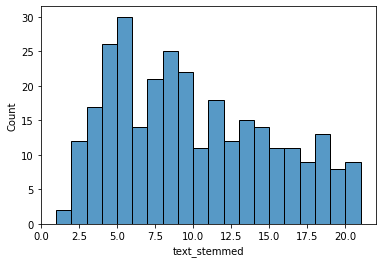

In [96]:
# seaborn visualization
sns.histplot(sentence_length, binwidth=1)

In [97]:
# five number summary
sentence_length.describe()

count    300.000000
mean       9.550000
std        5.134398
min        1.000000
25%        5.000000
50%        9.000000
75%       13.250000
max       21.000000
Name: text_stemmed, dtype: float64

> 💡 Insights:
> - On average, the sentence length in our data is 9-10 words
> - The minimum is only 1 word, and **the maximum is 21 words**

You can use this information futher to decide the value of `maxlength` parameter on pad sequence process.

## Cross Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. We use common variation from Cross Validation: **train/test split**. The procedure involves taking a dataset and dividing it into two subsets. 

- Train Dataset: Used to fit the machine learning model.
- Test Dataset: Used to evaluate the fit machine learning model.

The objective is to estimate the performance of the machine learning model on new data: data not used to train the model. Let's split using 75:25 proportion

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['text_no_stopwords'].values, df['Sentiment'].values, test_size=0.3)

# checking the data split
print('sentiment text: ', X_train[0])
print('sentiment: ', y_train[0])

sentiment text:  4glte bogor area 3 tanggap
sentiment:  0


In [98]:
from sklearn.model_selection import train_test_split

- Feature: text_stemmed
- Target: Sentiment

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df['text_stemmed'],
                                                    df['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=123)

print("TRAIN:", X_train.shape)
print("TEST:", X_test.shape)

TRAIN: (225,)
TEST: (75,)


In [101]:
# checking the data split
print("CLEANED TEXT (feature):", X_train.iloc[0])
print("SENTIMENT (target):", y_train.iloc[0])

CLEANED TEXT (feature): glte bogor area sudah bulan tidak ada tanggap yang jelas
SENTIMENT (target): 0


## Tokenization

Tokenization is a way of separating a piece of text into smaller units called tokens. We are using the TensorFlow (Keras) [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to automate the tokenization of our training data. First, we create the Tokenizer object, providing the maximum number of words to keep in our vocabulary after tokenization, as well as an out of vocabulary token to use for encoding test data words we have not come across in our training, without which these previously-unseen words would simply be dropped from our vocabulary and mysteriously unaccounted for. After the Tokenizer has been created, we then fit it on the training data. Remember that testing data do not need to be fit with tokenizer due to data leakage.

Parameter:

- `num_words`: the maximum number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
- `oov_token`: we use $<$OOV$>$ to handle out-of-vocabulary words. $<$OOV$>$ token will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls.

Note: In NLP, the term `token` can be either word, character, or subword. In this particular case, tokens means `words`

In [102]:
from keras.preprocessing.text import Tokenizer

In [103]:
# define number of words to keep during conversion (can be tuned)
num_words = len(unique_words)-427
num_words # only consider unique words, only 368 words (based on the highest word frequency)

368

In [104]:
# converting the strings into integers using Tokenizer 
# instantiating the tokenizer
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')

# only fit on data train
tokenizer.fit_on_texts(X_train)

`num_words`: can be tuned
- The bigger it is, the more we allow the model to be more specific
- The smaller it is, then, we only involve words that often appear

A byproduct of the tokenization process is the creation of a word index, which maps words in our vocabulary to their numeric representation, a mapping which will be essential for encoding our sequences. Since we will reference this later to print out, we assign it a variable here to simplify a bit.

In [105]:
# checking the word index and find out the size vocabulary of the dataset
# size of vocabulary are not affected by defined num_words
word_index = tokenizer.word_index
print('The size of dataset vocab is: ', len(word_index))

The size of dataset vocab is:  672


Since neural networks work by performing computation on numbers, passing in a bunch of words won't work. Now that we have a word to numeric representation mapping of our vocabulary, let's use it to encode our sequences. Here, we are converting **from words sequence to numbers sequence**, where each of those numbers match up in the index to the corresponding words.

In [106]:
# before mapping
sample_text_stemmed

'keluh tidak tanggap bikin emosi saja pulsa curi terus soak deh masa tiap hari pulsa kurang bisa hari'

In [107]:
# after mapping
tokenizer.texts_to_sequences([sample_text_stemmed])

[[189, 2, 201, 65, 1, 15, 28, 1, 97, 1, 190, 121, 162, 19, 28, 132, 17, 19]]

> 💡 Note: The tokenizer will only convert to sequences as many as `num_words` stated inside `Tokenizer()`

In [109]:
# converting train and test sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

#sample after mapping
print('Training sequence: ', train_sequences[0])
print('Testing sequence: ', test_sequences[0])

Training sequence:  [142, 300, 89, 11, 90, 2, 13, 201, 3, 143]
Testing sequence:  [43, 295, 137, 2, 1, 134, 1, 108, 101, 255, 82]


## Pad Sequence

We need our encoded sequences to be of **the same length**. We just found out the length of the longest sequence (on EDA), and will use that to pad all other sequences with extra '0's at the beginning ('pre') and will also truncate any sequences longer than maximum length from the beginning ('pre') as well. Here we use the TensorFlow (Keras) [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) module to accomplish this. You can look at the documentation for additional padding options.

In [110]:
from keras.preprocessing.sequence import pad_sequences

In [111]:
# for illustration only
pad_sequences([[1, 2, 3],
               [1, 2, 3, 4, 5, 6]], maxlen=5, padding='pre', truncating='post')

array([[0, 0, 1, 2, 3],
       [1, 2, 3, 4, 5]])

- `maxlen`: maximum length of text data
- `padding`: if the sequence is too short, how do you want it to be padded? is it `pre`/`post`?
- `truncating`: if the sequence is too long, which way do you want to cut it? is it `pre`/`post`?

In [112]:
# padding the train and test sequences
max_length = 20 # around the maximum sentence length of the data (may be changed but not too extreme)
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

print("Shape of train sequences:", train_padded.shape)
print("Shape of test sequences:", test_padded.shape)

Shape of train sequences: (225, 20)
Shape of test sequences: (75, 20)


In [113]:
# sample after padding
print(X_train[0])
print(train_sequences[0])
print(train_padded[0])

boikot guna produk bangsa sendiri
[142, 300, 89, 11, 90, 2, 13, 201, 3, 143]
[  0   0   0   0   0   0   0   0   0   0 142 300  89  11  90   2  13 201
   3 143]


## Quick Recap

Here is the workflow we have done so far:

1. Load Dataset
2. Target Preprocessing
3. Text (Feature) Preprocessing: case folding, text cleansing, text normalization, stemming, stopwords removal
4. EDA: count unique words, count sentence length
5. Cross Validation
6. Tokenization
7. Pad Sequence

In [115]:
sample_idx = 1

print("CLEANED TEXT:", X_train.iloc[sample_idx])
print("AFTER TOKENIZE:", train_sequences[sample_idx])
print("AFTER PADDING (FEATURE):\n", train_padded[sample_idx])
print("SENTIMENT (TARGET):", y_train.iloc[sample_idx])

CLEANED TEXT: untuk tembak paket dari masih ganggu ya
AFTER TOKENIZE: [59, 301, 22, 14, 26, 108, 21]
AFTER PADDING (FEATURE):
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  59 301  22  14  26
 108  21]
SENTIMENT (TARGET): 0


🔎 **Discussion**: 

We have successfully encode words to integers using `Tokenizer` and we can observe from the `word_index` that:

- `'jaring'` is encoded as 6
- `'saya'` is encoded as 7
- `'sinyal'` is encoded as 8
- `'aku'` is encoded as 229

Suppose this number will represent the word similarity, where the closer the distance means the two words are similar. Since `distance('saya', 'jaring') = 1` and `distance('saya', 'aku') = 222`, can we say that `'saya'` is more similar to `'jaring'` than to `'aku'`? Explain why?

> Cannot, because `'saya'` is semantically more similar to `'aku'` than to `'jaring'`

## Building the model: Text Classification Model

Before we fit the `train_padded` into our model, let's us understand about embedding layer.

### Embedding Layer

Embedding layer captures the **semantic meaning** of the input by placing semantically similar inputs close together. It map **high-dimensional input into a lower-dimensional** space such that similar inputs are nearby.

- The following illustration shows an Embedding layer that maps 6 dimension input (6 unique words) into 4-dimensional word embedding vector.
![](assets/embedding_layer.png)

- Word embedding can capture semantic meaning, vectors that placed near to each other are considered have the same meaning.
![](assets/word_embedding.png)


> 💡 Additional reference for more detailed information how Embedding Layer works: [Understanding Word2Vec with Gensim and Elang](https://tomytjandra.github.io/blogs/python/natural-language-processing/gensim/2020/04/24/understanding-word2vec-with-gensim-and-elang.html)

Keras offers an [Embedding layer](https://keras.io/api/layers/core_layers/embedding/) that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer.

Parameters:
- `input_dim`: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
- `output_dim`: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. `output_dim` size is $2^n$ no more larger than `input_dim`'s size. 
- `input_length`: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

The Embedding layer takes the integer-encoded vocabulary. These vectors are learned as the model trains. The output are in 3 dimensions: `(batch_size, input_length, output_dim)`.

In [117]:
# for illustration purpose only
# imagine this is the encoded text with:
# vocabulary size = 100
# sentences = 20
# length of each sentence = 10

np.random.seed(123)
input_array = np.random.randint(100, size=(20, 10))
input_array

array([[66, 92, 98, 17, 83, 57, 86, 97, 96, 47],
       [73, 32, 46, 96, 25, 83, 78, 36, 96, 80],
       [68, 49, 55, 67,  2, 84, 39, 66, 84, 47],
       [61, 48,  7, 99, 92, 52, 97, 85, 94, 27],
       [34, 97, 76, 40,  3, 69, 64, 75, 34, 58],
       [10, 22, 77, 18, 15, 27, 30, 52, 70, 26],
       [80,  6, 14, 75, 54, 71,  1, 43, 58, 55],
       [25, 50, 84, 56, 49, 12, 18, 81,  1, 51],
       [44, 48, 56, 91, 49, 86,  3, 67, 11, 21],
       [89, 98,  3, 11,  3, 94,  6,  9, 87, 14],
       [83, 70, 12, 54, 27, 38, 17, 61, 74, 99],
       [99, 65, 47, 16,  5, 86, 46, 15, 59, 40],
       [25, 45, 49,  0, 35, 29,  1, 83, 68, 30],
       [ 7, 93, 60, 65, 76, 67, 44, 51,  7, 88],
       [70, 13, 28, 63, 84, 36, 96, 40, 88, 63],
       [58, 77,  8, 78,  6, 65, 94, 70, 40, 74],
       [76, 76, 25,  7, 13, 44,  1, 41, 78, 56],
       [87, 63, 97,  3, 17, 88, 87, 69, 97, 50],
       [ 2, 18, 46, 45, 57, 35, 18, 91, 46, 54],
       [73, 81, 62, 67, 11, 26, 92, 75, 10,  3]])

In [118]:
model_embedding = tf.keras.Sequential(keras.layers.Embedding(input_dim=100, 
                                                             output_dim=32, 
                                                             input_length=10)
)
model_embedding.compile(optimizer='adam', loss='mse')
model_embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 32)            3200      
                                                                 
Total params: 3,200
Trainable params: 3,200
Non-trainable params: 0
_________________________________________________________________


In [119]:
# check the output dimension
output_array = model_embedding.predict(input_array)
output_array.shape

(20, 10, 32)

### Building the Sequential Model

Now, you have understand how embedding layers work. Let's build the sequential model using stacked LSTM.

**🔎 Knowledge Check**

- In the output layer:
    - How many units should we use: `1`
    - Activation function: `sigmoid`
- During model compilation:
    - Loss function: `binary cross entropy`
    - Metrics: `accuracy`
- What type of RNN architecture is it? `many-to-one`

In [121]:
tf.random.set_seed(123)

embedding_size = 128

model_lstm = keras.models.Sequential([
    keras.layers.Embedding(input_dim=num_words, 
                           output_dim=embedding_size, 
                           input_length=max_length),
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.LSTM(units=64, return_sequences=False),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='bce', metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 128)           47104     
                                                                 
 lstm (LSTM)                 (None, 20, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 129,601
Trainable params: 129,601
Non-trainable params: 0
_________________________________________________________________
None


Let's fit the training data and use the test data as validation.

> 💡 Note: Using test data as validation is not a best practice. In this case, we only have 300 tweets. If we have enough data, we can perform test-validation-test split instead of just a train-test split.

In [122]:
model_lstm.fit(
    x=train_padded, y=y_train,
    validation_data=(test_padded, y_test),
    epochs=10)

Epoch 1/10
8/8 [==============================] - 5s 152ms/step - loss: 0.6937 - accuracy: 0.5067 - val_loss: 0.6852 - val_accuracy: 0.5867
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 0.6843 - accuracy: 0.5200 - val_loss: 0.6699 - val_accuracy: 0.5867
Epoch 3/10
8/8 [==============================] - 0s 30ms/step - loss: 0.6741 - accuracy: 0.5200 - val_loss: 0.6486 - val_accuracy: 0.5867
Epoch 4/10
8/8 [==============================] - 0s 27ms/step - loss: 0.6349 - accuracy: 0.5511 - val_loss: 0.6297 - val_accuracy: 0.6800
Epoch 5/10
8/8 [==============================] - 0s 28ms/step - loss: 0.5544 - accuracy: 0.8044 - val_loss: 0.7177 - val_accuracy: 0.5067
Epoch 6/10
8/8 [==============================] - 0s 30ms/step - loss: 0.4710 - accuracy: 0.7867 - val_loss: 0.6702 - val_accuracy: 0.5733
Epoch 7/10
8/8 [==============================] - 0s 27ms/step - loss: 0.3161 - accuracy: 0.9022 - val_loss: 0.6305 - val_accuracy: 0.7067
Epoch 8/10
8/8 [==========

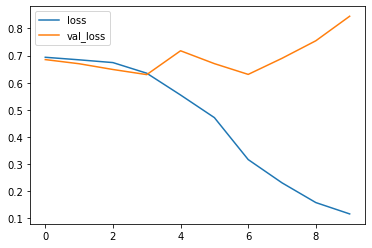

In [123]:
# plotting the loss and validation loss of the model
plt.plot(model_lstm.history.history['loss'], label='loss')
plt.plot(model_lstm.history.history['val_loss'], label='val_loss')
plt.legend()

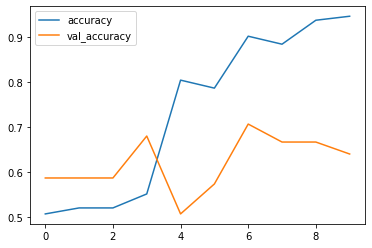

In [124]:
# plotting the accuracy and validation accuracy of the model
plt.plot(model_lstm.history.history['accuracy'], label='accuracy')
plt.plot(model_lstm.history.history['val_accuracy'], label='val_accuracy')
plt.legend()

**💬 Discussion**

How is the performance of `model_lstm`? What should we improve further?

> ...

**Additional Material: ModelCheckpoint**

Below, we use ModelCheckpoint to save the best model by its validation accuracy. [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) is a Keras callback to save model weights or entire model at a specific frequency or whenever a quantity (for example, training loss) is optimum when compared to last epoch/batch. ModelCheckpoint callback provides:
- ModelCheckpoint captures the weights of the model or entire model during training
- It allows us to specify a quantity to monitor, such as loss or accuracy on training or validation dataset.
- Automatically it can save model weights or entire model whenever monitored quantity is optimum when compared to last epoch/batch
- saves model weights or entire model in two formats (“tf” and “h5”)

*Reminder that ModelCheckpoint is not the main material so take it as additional information.*

In [127]:
checkpoint = ModelCheckpoint("best_model_lstm.hdf5", monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='auto', save_weights_only=False)
history_lstm = model_lstm.fit(train_padded, y_train, epochs = 30, validation_data = (test_padded, y_test), callbacks=[checkpoint])

Epoch 1/30
7/8 [=========================>....] - ETA: 0s - loss: 0.1292 - accuracy: 0.9509
Epoch 00001: val_accuracy improved from -inf to 0.69333, saving model to best_model_lstm.hdf5
8/8 [==============================] - 0s 53ms/step - loss: 0.1287 - accuracy: 0.9511 - val_loss: 0.6919 - val_accuracy: 0.6933
Epoch 2/30
7/8 [=========================>....] - ETA: 0s - loss: 0.0882 - accuracy: 0.9777
Epoch 00002: val_accuracy did not improve from 0.69333
8/8 [==============================] - 0s 25ms/step - loss: 0.0897 - accuracy: 0.9778 - val_loss: 0.7158 - val_accuracy: 0.6533
Epoch 3/30
7/8 [=========================>....] - ETA: 0s - loss: 0.0592 - accuracy: 0.9911
Epoch 00003: val_accuracy improved from 0.69333 to 0.70667, saving model to best_model_lstm.hdf5
8/8 [==============================] - 1s 84ms/step - loss: 0.0590 - accuracy: 0.9911 - val_loss: 0.8264 - val_accuracy: 0.7067
Epoch 4/30
7/8 [=========================>....] - ETA: 0s - loss: 0.0411 - accuracy: 0.9866
Ep

Epoch 30/30
7/8 [=========================>....] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.76000
8/8 [==============================] - 0s 28ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.3236 - val_accuracy: 0.7467


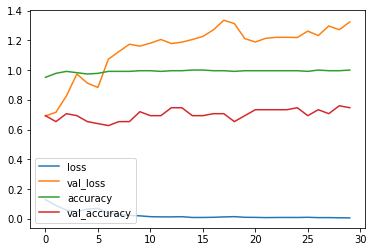

In [128]:
# plotting the loss and validation loss of the model
plt.plot(history_lstm.history['loss'], label='loss')
plt.plot(history_lstm.history['val_loss'], label = 'val_loss')
plt.legend()

# plotting the accuracy and validation accuracy of the model
plt.plot(history_lstm.history['accuracy'], label= 'accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='val_accuracy')
plt.legend()

Based on the training accuracy plot, its seem that our model able to decrese its validation and training loss but the accuracy stays the same. It might be because our model could not fit to the data. 

**Dive deeper: Tweak LSTM model**

Tweak the model layers and/or the parameter to raise the validation accuracy!

In [35]:
# YOUR CODE HERE

# GRU Layer

The workflow of the Gated Recurrent Unit (GRU) is the same as the RNN, but the difference is in the operation and gates associated with each GRU unit. It combines the forget and input gates into a single update gate. **GRU is computationally more efficient than LSTM** due to its fewer parameters and less complex structure. To solve the problem faced by standard RNN, GRU incorporates the two gate operating mechanisms called Update gate and Reset gate.

<figure>
    <center>
    <img src="assets/GRU.png" width="50%">
<figcaption>Source: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21</figcaption> 
    </center>
</figure>

- **Update gate**: The update gate is responsible for determining the amount of previous information that needs to pass along the next state. This is really powerful because the model can decide to copy all the information from the past and eliminate the risk of vanishing gradient.

- **Reset gate**: The reset gate is used from the model to decide how much of the past information is needed to neglect; in short, it decides whether the previous cell state is important or not.     

Mathematically, GRU can be illustrated as below:

<figure>
    <center>
    <img src="assets/LSTM3-var-GRU.png" width="70%">
    <figcaption>Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/</figcaption> 
    </center>
</figure>

First we define a next hidden state vector using
$$h_t = tanh(W_{xh} x_t + W_{hh} (r_t\odot h_{t-1}) + b_h)$$
where $r_t = \sigma (W_{xr} x_t + W_{hr} h_{t-1} + b_r)$ is known as the **reset gate**, since it determines how much of the old state we want to add to the current observation. Once we have computed the candidate new state, the model computes the actual new state using the candidate state for some dimensions and the old state for others: $$h_t = z_t \odot h_{t-1} + (1 - z_t) \odot \widetilde{h}_t$$ where $z_t = \sigma (W_{xz} x_t + W_{hz} h_{t-1} + b_z)$ is the **update gate**

> For more detailed information you can visit the documentation on [GRU layers](https://keras.io/api/layers/recurrent_layers/gru/)

In [130]:
tf.random.set_seed(123)

embedding_size = 128

model_gru = keras.models.Sequential([
    keras.layers.Embedding(input_dim=num_words, 
                           output_dim=embedding_size, 
                           input_length=max_length),
    keras.layers.GRU(units=64, return_sequences=True),
    keras.layers.GRU(units=64, return_sequences=False),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=1, activation='sigmoid')
])
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model_gru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 128)           47104     
                                                                 
 gru (GRU)                   (None, 20, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 109,377
Trainable params: 109,377
Non-trainable params: 0
_________________________________________________________________
None


In [132]:
# compare the amounts of parameters with lstm model
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 128)           47104     
                                                                 
 lstm (LSTM)                 (None, 20, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 129,601
Trainable params: 129,601
Non-trainable params: 0
_________________________________________________________________


> 💡 Note: Compare the number of parameters of `model_lstm` and `model_gru`, specifically on the stacked layer. GRU should have less parameters than LSTM.

In [133]:
model_gru.fit(
    x=train_padded, y=y_train,
    validation_data=(test_padded, y_test),
    epochs=10)

Epoch 1/10
8/8 [==============================] - 5s 130ms/step - loss: 0.6911 - accuracy: 0.5156 - val_loss: 0.6857 - val_accuracy: 0.5867
Epoch 2/10
8/8 [==============================] - 0s 23ms/step - loss: 0.6715 - accuracy: 0.5244 - val_loss: 0.6707 - val_accuracy: 0.5867
Epoch 3/10
8/8 [==============================] - 0s 22ms/step - loss: 0.6302 - accuracy: 0.5556 - val_loss: 0.6394 - val_accuracy: 0.5733
Epoch 4/10
8/8 [==============================] - 0s 20ms/step - loss: 0.5077 - accuracy: 0.7644 - val_loss: 0.6555 - val_accuracy: 0.6267
Epoch 5/10
8/8 [==============================] - 0s 22ms/step - loss: 0.3611 - accuracy: 0.8844 - val_loss: 0.8339 - val_accuracy: 0.5867
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 0.2442 - accuracy: 0.8889 - val_loss: 0.7142 - val_accuracy: 0.6400
Epoch 7/10
8/8 [==============================] - 0s 20ms/step - loss: 0.1612 - accuracy: 0.9289 - val_loss: 0.8284 - val_accuracy: 0.6667
Epoch 8/10
8/8 [==========

- LSTM: accuracy: 0.9467 - val_loss: 0.8452 - val_accuracy: 0.6400
- GRU: accuracy: 0.9778 - val_loss: 0.8095 - val_accuracy: 0.7733

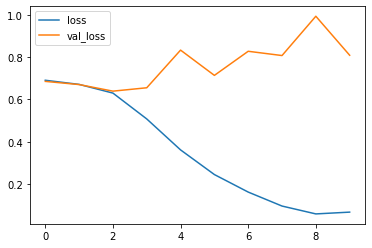

In [135]:
# plotting the loss and validation loss of the model
plt.plot(model_gru.history.history['loss'], label='loss')
plt.plot(model_gru.history.history['val_loss'], label='val_loss')
plt.legend()

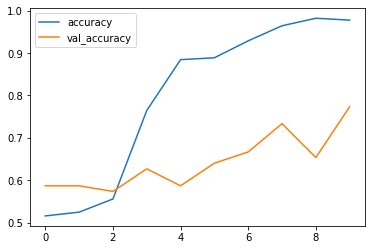

In [136]:
# plotting the accuracy and validation accuracy of the model
plt.plot(model_gru.history.history['accuracy'], label='accuracy')
plt.plot(model_gru.history.history['val_accuracy'], label='val_accuracy')
plt.legend()

# Variant of RNN: Bidirectional RNN

A typical state in an RNN (simple RNN, GRU, or LSTM) relies on the past and the present events. A state at time $t$ depends on the states $x_1, x_2, ... x_{t-1}$ and $x_t$. However, there can be situations where a prediction depends on the past, present, and future events. To enable straight (past) and reverse traversal of input (future), Bidirectional RNNs, or BRNNs, are used. A BRNN is a combination of two RNNs - **one RNN moves forward**, beginning from the start of the data sequence, and the other, **moves backward**, beginning from the end of the data sequence (Mind you; this is __not__ the same as the backpropagation process.). The network blocks in a BRNN can either be simple RNNs, GRUs, or LSTMs.

<figure>
    <center>
    <img src="assets/brnn.png" width="70%">
<!--     <figcaption>Source: http://colah.github.io/posts/2015-09-NN-Types-FP/</figcaption> -->
    </center>
</figure>

For example, suppose you want to solve the Named Entity Recognition problem, and you face these sentences:
1. *__Palu__ itu terletak di atas meja*
2. *Aku baru tau __Palu__ itu Ibukota dari Sulawesi Tengah*

Is 'Palu' a tool (martil) or a City? You can directly know the answer after you read the next words. Let's look at the second sentence and make it as if an input to BRNN.

<figure>
    <center>
    <img src="assets/brnn_example.png" width="70%">
    </center>
</figure>

Notice that output $Y_3$ has influence not only from word 'Aku', 'baru', 'tau' from input $X_0$ to $X_1$, but also from future words as well. 'itu Ibukota Sulawesi Tengah' sentence influence $Y_3$ output from layer $A'$ direction.

A BRNN has an additional hidden layer to accommodate the backward training process. At any given time $t$, the forward and backward hidden states are updated as follows:

$$\large A_t(Forward) = \phi (X_t * W_{XA}^{forward} + A_{t-1}(Forward) * W_{AA}^{forward} + b_A^{forward})$$

$$\large A_t(Backward) = \phi (X_t * W_{XA}^{backward} + A_{t-1}(Backward) * W_{AA}^{backward} + b_A^{backward})$$

where $\phi$ is the activation function, $W$, the weight matrix, and $b$, the bias. The hidden state at time $t$ is given by a combination of $A_t(Forward)$ and $A_t(Backward)$. The output at any given hidden state is:

$$\large O_t = H_t * W_{AY} + b_Y$$

## 🏄‍ Dive Deeper: Build BRNN Model

We can use Keras [Bidirectional](https://keras.io/api/layers/recurrent_layers/bidirectional/) layer. 
Syntactically, we will wrap the RNN layer with Bidirectional as follows:

```{python}
keras.layers.Bidirectional(keras.layers.___(...))
```

Where the `___` can be filled by types of RNN, such as:
- `SimpleRNN`
- `LSTM`
- `GRU`

In [ ]:
tf.random.set_seed(123)

embedding_size = ___

model_brnn = keras.models.Sequential([
    # embedding layer
    ___,
    
    # bidirectional RNN (SimpleRNN / LSTM / GRU)
    # if you want, you can stack 2 layers of bidirectional RNN too
    keras.layers.Bidirectional(keras.layers.LSTM(...)),
    keras.layers.Bidirectional(keras.layers.LSTM(...)),
    
    # dropout layer (if needed)
    ___,
    
    # output layer (mandatory)
    ___
])

model_brnn.compile(___)
print(model_brnn.summary())

In [ ]:
model_brnn.fit(___)

In [ ]:
# plotting the loss and validation loss of the model
plt.plot(model_brnn.history.history['loss'], label='loss')
plt.plot(model_brnn.history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# plotting the accuracy and validation accuracy of the model
plt.plot(model_brnn.history.history['accuracy'], label='accuracy')
plt.plot(model_brnn.history.history['val_accuracy'], label='val_accuracy')
plt.legend()

# Predict Unseen Tweet

**💬 Discussion**

We have built 3 different models, according to the loss and accuracy, which one is considered as the best model? Please define the variable below:

In [ ]:
best_model = ___

To predict unseen tweet using `best_model`, we have to treat it the same way as we treat the original text, which covers:

- Text Preprocessing
- Tokenization
- Pad Sequence

In [137]:
# define the preprocessing pipeline
def text_preprocessing(text):
    # case folding
    text = text.lower()
    
    # text cleansing
    text = text_cleansing(text)
    
    # text normalization
    text = normalize_text(text)
    
    # stemming
    text = stemmer.stem(text)
    
    return text

In [ ]:
# unseen tweet
new_tweet = "kok sekarang <PROVIDER_NAME> sinyalnya bapuk banget ya? hiksss :("

# preprocess
text_cleaned = text_preprocessing(new_tweet)
text_sequence = tokenizer.texts_to_sequences([text_cleaned])
seq_padded = pad_sequences(text_sequence, maxlen=max_length)

# prediction
pred_proba = best_model.predict(seq_padded)
pred_proba

In [ ]:
prob2label = lambda x: 'Negative' if x <= 0.5 else 'Positive'
prob2label(pred_proba)

> From here, if you are willing to build an application that predict sentiment based on user input, you have to save the following object:
> - model configuration as json file
> - model weights as HDF5 file
> - tokenizer as pickle file

```{python}
import pickle

# serialize model to JSON
model_json = model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model/model-weights.h5")

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
```

**Additional Example: Bidirectional GRU Model**

In [36]:
model2 = Sequential()

model2.add(Embedding(num_words, embedding_size, input_length=max_length))
model2.add(Bidirectional(GRU(12,dropout=0.4, kernel_regularizer=regularizers.l2(0.05), recurrent_regularizer=regularizers.l2(0.05))))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("best_model_bGRU.hdf5", monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='auto', save_weights_only=False)
history_bgru = model2.fit(train_padded, y_train, epochs = 20, validation_data = (test_padded, y_test), callbacks=[checkpoint2])

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 4.0621 - accuracy: 0.5143
Epoch 00001: val_accuracy improved from -inf to 0.44444, saving model to best_model_bGRU.hdf5
7/7 [==============================] - 13s 438ms/step - loss: 4.0621 - accuracy: 0.5143 - val_loss: 3.9684 - val_accuracy: 0.4444
Epoch 2/20
5/7 [====================>.........] - ETA: 0s - loss: 3.9114 - accuracy: 0.5875
Epoch 00002: val_accuracy did not improve from 0.44444
7/7 [==============================] - 0s 47ms/step - loss: 3.8912 - accuracy: 0.5762 - val_loss: 3.7892 - val_accuracy: 0.4444
Epoch 3/20
4/7 [================>.............] - ETA: 0s - loss: 3.7428 - accuracy: 0.5625
Epoch 00003: val_accuracy did not improve from 0.44444
7/7 [==============================] - 0s 36ms/step - loss: 3.7093 - accuracy: 0.5762 - val_loss: 3.6207 - val_accuracy: 0.4444
Epoch 4/20
4/7 [================>.............] - ETA: 0s - loss: 3.5712 - accuracy: 0.5938
Epoch 00004: val_accuracy did not improve 

**Model Evaluation**

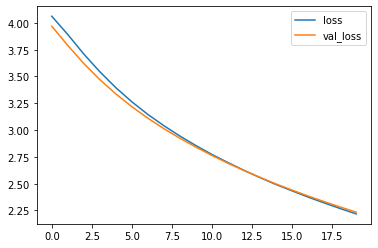

In [37]:
## Bidirectional BRU Model 
# plotting the loss and validation loss of the model
plt.plot(history_bgru.history['loss'], label='loss')
plt.plot(history_bgru.history['val_loss'], label = 'val_loss')
plt.legend()

Based on validation loss and training loss. Our model has succesfully decreasing its loss. 

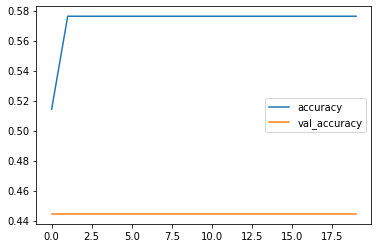

In [38]:
# plotting the accuracy and validation accuracy of the model
plt.plot(history_bgru.history['accuracy'], label= 'accuracy')
plt.plot(history_bgru.history['val_accuracy'], label='val_accuracy')
plt.legend()

But if we look at the validation accuracy plot, our model has not reached the best accuracy yet, and it might have to be tuning again to increase accuracy value.

In [39]:
best_model = keras.models.load_model("best_model_bgru.hdf5")

In [40]:
test_loss, test_acc = best_model.evaluate(test_padded, y_test, verbose=2)
print('Model accuracy: ',test_acc)

3/3 - 2s - loss: 3.9684 - accuracy: 0.4444 - 2s/epoch - 719ms/step
Model accuracy:  0.4444444477558136


**Try on**

In [41]:
sentiment = ['Negatif','Positif']

sequence = tokenizer.texts_to_sequences(['sinyalnya bapuk'])
test = pad_sequences(sequence, maxlen=max_length)
sentiment[int(np.around(best_model.predict(test), decimals=0))]

'Negatif'

In [42]:
sequence = tokenizer.texts_to_sequences(['pulsa murah'])
test = pad_sequences(sequence, maxlen=max_length)
sentiment[int(np.around(best_model.predict(test), decimals=0))]

'Negatif'

**Saving the model**

In [138]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model/model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model/model-weights.h5")
# print("Saved model to disk")

# # saving tokenizer
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print('Tokenizer saved')

# Additional: Audio Classification

Deep learning for audio can be used to make audio and music generation, virtual assistants, automatic speech recognition, and text to speech applications. There are multiple ways to build an audio classification model. You can use the waveform, tag sections of a wave file, or even use computer vision on the spectrogram image. In this section, we will break down how to understand audio data

## Libraries

In [44]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd

## Get the mini speech command dataset

We will use a tensorflow dataset called Mini Speech Commands.

In [59]:
DATASET_PATH = 'dataset/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='dataset')

182091776/182082353 [==============================] - 75s 0us/step


**Load the dataset**

The dataset's audio clips are stored in eight folders corresponding to each speech command: no, yes, down, go, left, up, right, and stop.

In [60]:
def load_dataset(data_dir):
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[commands != 'README.md']
    return commands

In [61]:
commands = load_dataset(data_dir)
commands

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U9')

In [62]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'dataset\\mini_speech_commands\\go\\f264e0df_nohash_1.wav', shape=(), dtype=string)


In [63]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Understanding audio data

Sound is a vibration that propagates as an acoustic wave. Sound has some properties like frequency, amplitude, speed, and direction. When talking about basic usage of machine learning in this domain, frequency and amplitude are the important features. We use a microphone to capture the sound and then it's converted from analog sound to digital sound by sampling at consistent intervals of time. This is called the **sample rate**. The higher the sample rate the higher the quality of the sound. However, after a certain point the difference is not able to be detected by the human ear. The average sound sample rate is 48 kHz or 48,000 samples per second. The dataset we'll use in this module was sampled at 16kHz, so our data was sampled 16,000 times per second.

When we sample audio, we measure the **amplitude** or how loud the audio is, at a particular sample rate. We can then take that information and represent the **signal** in graphical format as a **waveform**. Another way to look at the audio information is by analyzing its **frequency** or pitch, which represents the number of complete waves per time period. The more waves, the higher the pitch. Also, audio can be recorded in different **channels**. For example stereo recordings have 2 channels, right and left.

Before streaming song services developed rapidly as they are today, there were times when you had to download your favorite songs at the *warnet*. If you do, you must be familiar with MP3 format files. There is one more popular format for storing audio files, namely WAV. One of the differences between these two formats is that MP3 is compressed, and WAV files are uncompressed. To put you into some perspective, imagine we have the same image; one with a low-quality resolution representing MP3 and one with a high-quality resolution representing WAV. The Mini Speech Commands dataset that we are using for this tutorial is stored in wave files that are all one second or less. 

Let's load up one of the wave files and take a look at how the tensor for the waveform looks. We will do this by calling a decode_audio function that will read the wave audio file and return the waveform tensor. The function gets the audio_binary with tf.io.read_file then uses tf.audio.decode_wav to get the audio waveform to a tensor format (range of: -1 to 1) and the sample_rate.

In [64]:
file_path = DATASET_PATH+'/down/0a9f9af7_nohash_0.wav'

def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

## This function has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

Define a function that creates labels using the parent directories for each file:

In [65]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

## This function has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

In [66]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

## This function has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

Build the training set to extract the audio-label pairs. We create a tf.data.Dataset with Dataset.from_tensor_slices and Dataset.map, using get_waveform_and_label defined earlier.

In [67]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

## Waveform

a **waveform** is a time series with the signal amplitude at each specific time, if we visualize one of those waveform samples we will get something like this:

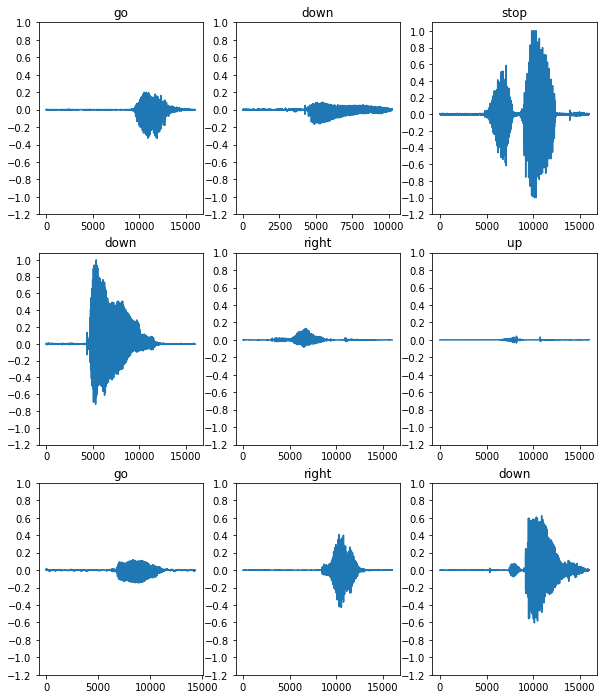

In [68]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Intuitively one might consider modeling this data like a regular time series (e.g. stock price forecasting) using some kind of RNN model, in fact, this could be done, but since we are using audio signals, a more appropriate choice is to transform the waveform samples into **spectrograms.**

## Spectrogram

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

In [69]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    
    return spectrogram

## This function has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

In [70]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
ipd.Audio(waveform, rate=16000)

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


A spectrogram is an image representation of the waveform signal. It allows you to visualize the amplitude as a function of frequency and time in the form of an image, where the 'x' axis represents time, the 'y' axis represents frequency, and the color represents the amplitude. It can be very useful when we want to evaluate the signal's frequency distribution over time. Below is the spectrogram representation of the waveform image.

In [71]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    
## This function has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

A spectrogram is a graph that represents the concentration of the frequency of the audio data. This means the brighter color in the spectrogram has a more concentrated sound than the darker color in the spectrogram, where the sound is nearly empty.

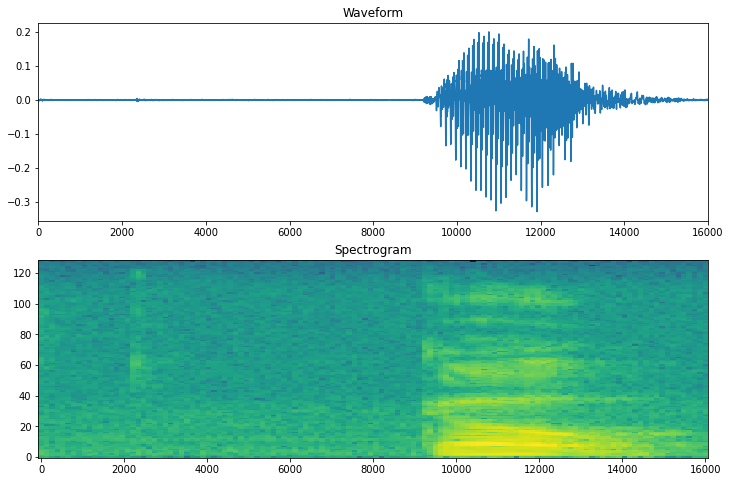

In [72]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

After converting the audio file into spectrogram image, you can use a convolutional neural network (CNN) model to training the data. Since we want to use RNN, the spectrogram must be converted to mel spectrogram and later converted into mel frequency cepstral coeffiecients (MFCC). The **mel scale** is the scale of pitches felt by the listener present in the same distance from one another. **Mel spectrogram** is a spectrogram where spectrum frequencies are converted into mel scale. The db scale mel spectrogram is a spectrogram that creates a graph between log scaled frequency and pitches.

Before converting to mfccs, we have to convert the spectrogram from linear scale to mel scale by creating a manual function. In the tensorflow library, you can use [tf.signal.mfccs_from_log_mel_spectrograms](https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms) to convert mel spectrograms to mfccs. In the tensorflow I/O module, we can do this automatically without creating our own function with [tfio.audio.melscale](https://www.tensorflow.org/io/api_docs/python/tfio/audio/melscale)

<figure>
    <center>
    <img src="assets/rnn_audio_preprocessing_pipeline.png">
       <figcaption> Source: Dokumentasi Pribadi</figcaption>
    </center>
</figure>

## Build the model

Now that you already know how to preprocess audio files, you can explore what model architecture you want to implement. For further reference, you can see page [tensorflow_simple-audio](https://www.tensorflow.org/tutorials/audio/simple_audio) and page [microsoft_intro-audio](https://docs.microsoft.com/en-us/learn/modules/intro-audio-classification-tensorflow/). You can also see the documentation regarding the [librosa](https://librosa.org/doc/latest/index.html) library. Librosa is often used for preprocessing and feature extraction on audio datasets.

In [ ]:
# YOUR CODE HERE

# 📝 Summary

Finally, we have reached the end of this course. And to summarize what we have learned in general, here's a few points that cover the course :

- Cleansing a text data is case-by-case process, but most common steps including: case folding, text cleansing and normalization, stemming, and remove stopwords.
- Sentences must be tokenized and encoded to corresponding index number. This process can be done using keras `Tokenizer`
- Sentences that have different length must be padded or truncated into the same length. This process can be done using keras `pad_sequences`
- Instead of using positional index, Embedding layer is placed on the first layer of network since it can capture semantic meaning of a word.
- GRU is computationally more efficient than LSTM, since it has fewer parameters but still use the gate mechanism.
- A Bidirectional RNN is a combination of two RNNs training the network in opposite directions, one from the beginning to the end of a sequence, and the other, from the end to the beginning of a sequence. It helps in analyzing the future events by not limiting the model's learning to past and present.
- To do audio classification with RNN, the data must be convert into MFCCs. It's a shorter process if we use CNN architecture because data preprocessing is only up to make spectogram images. 

# External Link

- http://colah.github.io/posts/2015-09-NN-Types-FP/
- https://www.tensorflow.org/tutorials/audio/simple_audio
- https://docs.microsoft.com/en-us/learn/modules/intro-audio-classification-tensorflow/1-introduction 
- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

**Dataset Citation**

Muhammad Okky Ibrohim and Indra Budi. 2019. Multi-label Hate Speech and Abusive Language Detection in Indonesian Twitter. In ALW3: 3rd Workshop on Abusive Language Online, 46-57. [github repository](https://github.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/blob/master/new_kamusalay.csv)

Rofiqoh, U., Perdana, R.S., & Fauzi, M.A. (2017). Analisis Sentimen Tingkat Kepuasan Pengguna Penyedia Layanan Telekomunikasi Seluler Indonesia Pada Twitter Dengan Metode Support Vector Machine dan Lexicon Based Features. Jurnal Pengembangan Teknologi Informasi Dan Ilmu Komputer, 1(12), 1725-1732. Diambil dari http://j-ptiik.ub.ac.id/index.php/j-ptiik/article/view/628

Tala, F. Z. (2003). A Study of Stemming Effects on Information Retrieval in Bahasa Indonesia. Thesis. Universiteti van Amsterdam The Netherlands. [pdf](https://eprints.illc.uva.nl/id/eprint/740/1/MoL-2003-02.text.pdf)